In [1]:
import numpy as np
import pandas as pd

xscaling = np.load("/home/guido/shared/physio2018/xsleepnet_scaling.npz")
xmean = xscaling["mean"]
xstd = xscaling["std"]

# check if nan values
if np.isnan(xmean).any() or np.isnan(xstd).any():
    print("nan values in xmean or xstd")

In [3]:
import pandas as pd

desc = pd.read_excel("../physioex/data/sleep_edf/subjects.xls")
table = pd.read_csv("../../../mne_data/table.csv")

desc = desc[["subject", "age", "sex (F=1)"]]
# drop the duplicates
desc = desc.drop_duplicates()
table["age"] = desc["age"].values
table["sex"] = desc["sex (F=1)"].map({1: 1, 2: 0}).values

# table = table.drop( columns=["Unnamed: 0"] )
table.to_csv("../../../mne_data/table.csv", index=False)

In [9]:
import pandas as pd
import numpy as np

# desc = pd.read_excel( "../physioex/data/sleep_edf/subjects.xls" )
table = pd.read_csv("../../../isruc/table.csv")

table["sex"] = table["gender"].map({"M": 0, "F": 1})

# sostituisci i valori "?" con la mediana
median_age = int(table[table["age"] != "?"]["age"].values.astype(int).mean())
print(median_age)
table["age"] = table["age"].replace("?", median_age)
table["age"] = table["age"].astype(int)

print(np.unique(table["age"]))

print(table)
table.to_csv("../../../isruc/table.csv", index=False)

49
[20 22 23 26 27 28 29 30 31 32 33 34 36 37 38 39 41 42 43 44 45 46 48 49
 50 51 52 53 55 56 57 58 59 60 61 62 64 65 66 67 68 69 70 72 73 75 76 77
 79 80 85]
     subject_id  num_samples  start_index  age gender  sex
0             0          880            0   64      M    0
1             1          964          880   52      M    0
2             2          943         1844   38      M    0
3             3          963         2787   27      M    0
4             4          875         3750   58      F    1
..          ...          ...          ...  ...    ...  ...
104         104          853        93769   38      M    0
105         105          814        94622   31      M    0
106         106         1000        95436   31      M    0
107         107          969        96436   33      M    0
108         108          796        97405   33      M    0

[109 rows x 6 columns]


In [15]:
table = pd.read_csv("../../../svuh/table.csv")
table = table.drop(columns=["Unnamed: 0"])
table["sex"] = table["sex"].map({"M": 0, "F": 1})


print(table)
table.to_csv("../../../svuh/table.csv", index=False)

    subject_id  num_samples  start_index  sex  age
0            0          748            0    0   54
1            1          882          748    0   48
2            2          826         1630    0   65
3            3          808         2456    0   52
4            4          813         3264    0   47
5            5          768         4077    1   63
6            6          925         4845    0   52
7            7          907         5770    0   38
8            8          900         6677    0   51
9            9          864         7577    0   51
10          10          811         8441    1   62
11          11          774         9252    0   56
12          12          916        10026    0   28
13          13          789        10942    0   53
14          14          822        11731    0   35
15          15          852        12553    0   49
16          16          752        13405    0   52
17          17          913        14157    1   41
18          18          787    

In [2]:
import requests
import xml.etree.ElementTree as ET
import numpy as np

# URL del file XML
url = "https://anon.erda.au.dk/share_redirect/DCuFnOpr1n/polysomnography/annotations-events-profusion/lab/full/homepap-lab-full-1600201-profusion.xml"

# Usa requests per ottenere il contenuto dall'URL
response = requests.get(url)
if response.status_code == 200:
    # Analizza il contenuto XML
    root = ET.fromstring(response.content)
    nsrr = root.findall("SleepStages")[0]
    print(len(nsrr))
else:
    print("Errore nel download del file:", response.status_code)

1133


In [7]:
import requests

# URL del file XML
url = "https://anon.erda.au.dk/share_redirect/DCuFnOpr1n/polysomnography/annotations-events-profusion/lab/split/homepap-lab-split-1600294-profusion.xml"

# Percorso dove salvare il file XML
file_path = "/home/guido/shared/hpap/download/lab-split-1600294-profusion.xml"

# Usa requests per ottenere il contenuto dall'URL
response = requests.get(url)
if response.status_code == 200:
    # Salva il contenuto in un file locale
    with open(file_path, "wb") as file:
        file.write(response.content)
    print(f"File salvato con successo in {file_path}")
else:
    print("Errore nel download del file:", response.status_code)

File salvato con successo in /home/guido/shared/hpap/download/lab-split-1600294-profusion.xml


In [33]:
import pyedflib

f = pyedflib.EdfReader("/home/guido/shared/hpap/download/lab-full-1600001.edf")
print(f.getSignalLabels())

ECG1 = f.readSignal(f.getSignalLabels().index("ECG1"))
ECG2 = f.readSignal(f.getSignalLabels().index("ECG2"))
ECG3 = f.readSignal(f.getSignalLabels().index("ECG3"))

f.close()

['CannulaFlow', 'Airflow', 'Chest', 'ABD', 'Snore', 'M1', 'M2', 'C3', 'C4', 'O1', 'O2', 'F3', 'F4', 'FPz', 'E1', 'E2', 'ECG1', 'ECG2', 'ECG3', 'Lchin', 'Rchin', 'Cchin', 'Lleg1', 'Lleg2', 'Rleg1', 'Rleg2', 'SAO2', 'Pulse', 'Pleth', 'MaskFlow', 'DHR']


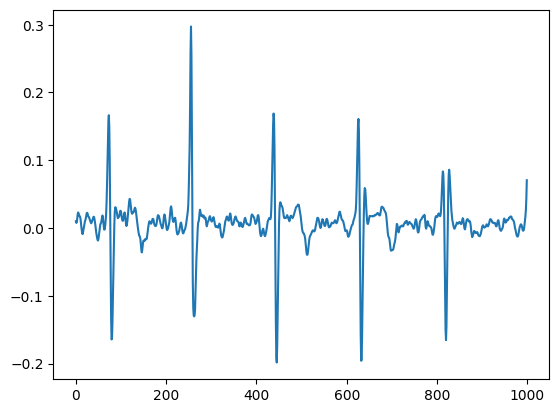

In [54]:
from matplotlib import pyplot as plt

meanECG = np.mean([ECG1, ECG2, ECG3], axis=0)

plt.plot((ECG2 - ECG1)[2000:3000])

In [19]:
import pandas as pd

# Leggi il file XML
tree = ET.parse("/home/guido/shared/hpap/download/home-1600005-nsrr.xml")
root = tree.getroot()

# Estrai le annotazioni dal file XML
annotations = []
for child in root:
    annotations.append(child.text)

# Scrivi le annotazioni in un file CSV
df = pd.DataFrame(annotations, columns=["Annotation"])
df.to_csv("/home/guido/shared/hpap/download/home-1600005-nsrr.csv", index=False)

# Ora puoi leggere il file di annotazioni con MNE
annt = mne.read_annotations("/home/guido/shared/hpap/download/home-1600005-nsrr.csv")

channel_names = raw.info["ch_names"]
print("Channel names:", channel_names)

# Ottieni le proprietà del segnale
# data = raw.get_data()

# Stampa le proprietà del segnale
# for i, channel_name in enumerate(channel_names):
#    print(f"Channel: {channel_name}")
#    print(f"Signal min: {data[i].min()}")
#    print(f"Signal max: {data[i].max()}")
#    print(f"Signal mean: {data[i].mean()}")

KeyError: 'onset'

In [56]:
import pandas as pd
import os

descriptor = "https://anon.erda.au.dk/share_redirect/DCuFnOpr1n/datasets/homepap-baseline-harmonized-dataset-0.2.0.csv"
records = pd.read_csv(descriptor)["nsrrid"].values
records = [str(record) for record in records]
data_path = "/home/guido/shared/hpap/download/"

# check for all the records if there is at least one .edf file for each record.
# print the missing records

missing_records = []
list_of_records = os.listdir(data_path)
list_of_records = [record for record in list_of_records if record.endswith(".edf")]

for record in records:
    num_files = len([file for file in list_of_records if record in file])
    if num_files == 0:
        missing_records.append(record)

print(len(missing_records))
print(missing_records)

30
['1600008', '1600014', '1600016', '1600037', '1600049', '1600050', '1600051', '1600066', '1600067', '1600073', '1600083', '1600106', '1600117', '1600120', '1600143', '1600152', '1600153', '1600176', '1600190', '1600220', '1600222', '1600227', '1600238', '1600248', '1600277', '1600302', '1600309', '1600329', '1600338', '1600369']


In [1]:
import psg_utils as ut

In [ ]:
ut.downlaod.download_dataset("phys", "/home/guido/shared/phys/")

In [6]:
import numpy as np
import h5py

subject = "/home/guido/shared/dreem/h5/dodh/095d6e40-5f19-55b6-a0ec-6e0ad3793da0.h5"
with h5py.File(subject, "r") as f:
    data = {key: f[key][()] for key in f.keys()}

print(data.keys())
print(data["y"].shape)
print(data["label"].shape)

dict_keys(['X1', 'X2', 'label', 'y'])
(5, 1081)
(1, 1081)


In [1]:
import numpy as np
import pandas as pd
import os


def online_variance(data):

    shape = data.shape[1:]

    n = 0
    mean = 0
    M2 = 0

    for x in tqdm(data):
        x = np.reshape(x, -1).astype(np.double)

        n = n + 1
        delta = x - mean
        mean = mean + delta / n
        M2 = M2 + delta * (x - mean)

    variance = M2 / (n - 1)

    variance = np.reshape(variance, shape)
    mean = np.reshape(mean, shape)

    return mean.astype(np.float32), np.sqrt(variance).astype(np.float32)

In [113]:
datasets = ["mne_data", "isruc", "mass", "svuh", "dcsm"]

num_channels = [3, 1, 3, 4, 4]

for dataset, num_channel in zip(datasets, num_channels):
    dataset_folder = "/home/guido/" + dataset + "/"
    table_path = os.path.join(dataset_folder, "table.csv")
    table = pd.read_csv(table_path)

    print("Computing scaling xsleepnet for", dataset)
    signal_path = os.path.join(dataset_folder, "xsleepnet.dat")
    X = np.memmap(
        signal_path,
        dtype="float32",
        mode="r",
        shape=(int(np.sum(table["num_samples"].values)), num_channel, 29, 129),
    )

    mean, std = online_variance(X)
    np.savez(os.path.join(dataset_folder, "xsleepnet_scaling.npz"), mean=mean, std=std)

    print("Computing scaling raw for", dataset)
    signal_path = os.path.join(dataset_folder, "raw.dat")
    X = np.memmap(
        signal_path,
        dtype="float32",
        mode="r",
        shape=(int(np.sum(table["num_samples"].values)), num_channel, 3000),
    )

    mean, std = online_variance(X)
    np.savez(os.path.join(dataset_folder, "raw_scaling.npz"), mean=mean, std=std)

  0%|          | 0/194444 [00:00<?, ?it/s]

 40%|████      | 231987/578939 [07:54<11:35, 498.91it/s]

In [107]:
real_mean, real_std = np.mean(X, axis=0), np.std(X, axis=0)

print(real_mean.shape, real_std.shape)

print("Error in mean: ", np.sum(np.abs(mean - real_mean)))
print("Error in std: ", np.sum(np.abs(std - real_std)))

(3, 29, 129) (3, 29, 129)
Error in mean:  6.361679
Error in std:  4.466608


In [108]:
print("Computing the scaling")
scaled = (X - mean) / std

Computing the scaling


In [109]:
print(scaled.shape[0])
# select 1000 samples from scaled
# scaled = scaled[: scaled.shape[0] // 10 ]

print(scaled[:, 0].mean(axis=0).mean(), scaled[:, 0].std(axis=0).mean())

54197
-4.6929585e-09 0.99998534


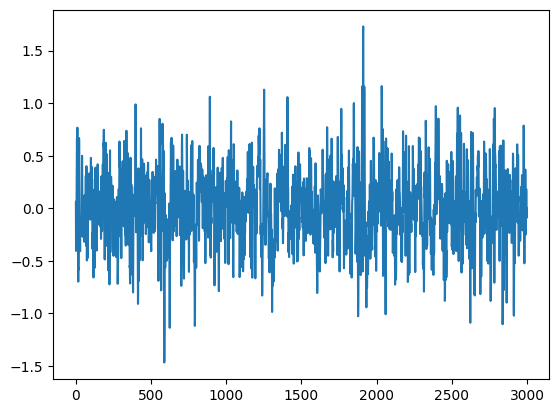

In [32]:
# plot X[1]

from matplotlib import pyplot as plt

x = (X[100, 0, :] - mean[0]) / std[0]
plt.plot(x)

In [24]:
filepath = "/home/guido/dcsm/data/sleep/DCSM/"

for file in os.listdir(filepath):
    file = filepath + file + "/"
    hyp = pd.read_csv(os.path.join(file, "hypnogram.ids"), header=None)

    stages = hyp.iloc[:, 2]
    durations = hyp.iloc[:, 1]

    # for each stage compute its overall duration during the night

    for stage in np.unique(stages):
        print(
            f"stage {stage}: {np.sum(durations[stages == stage])/np.sum(durations):.2f}"
        )

    break

stage N1: 0.03
stage N2: 0.18
stage N3: 0.07
stage REM: 0.09
stage W: 0.62


In [11]:
# for each subject_id in table get the starting_index and the num_samples

for subject_id, starting_index, num_samples in zip(
    table["subject_id"], table["start_index"], table["num_samples"]
):
    print(f"subject_id: {subject_id}")
    print(f"starting_index: {starting_index}")
    print(f"num_samples: {num_samples}")

    # get the labels for this subject
    subject_labels = y[starting_index : starting_index + num_samples]
    print(subject_labels[:10])
    print(subject_labels.shape)
    # crop the first 30 minutes of the signal and the last 30 minutes considering that each sample is 30 seconds
    subject_labels = subject_labels[60 * 2 :]
    print(subject_labels.shape)
    # print the label distribution for this subject
    for label in np.unique(subject_labels):
        print(
            f"label {label}: {np.sum(subject_labels == label)/len(subject_labels):.2f}"
        )
    break
    print()

subject_id: 0
starting_index: 0
num_samples: 2694
[2 2 2 2 2 2 2 2 2 2]
(2694,)
(2574,)
label 0: 0.65
label 1: 0.03
label 2: 0.17
label 3: 0.07
label 4: 0.09
